In [1]:
import tqdm
import inspect
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from helper_functions import warn, var_fecha, plot_distribucion, plot_multiple_distribuciones, seleccionar_distribuciones, comparar_distribuciones

In [2]:
warnings.warn = warn

In [3]:
# Importa csv
df1 = pd.read_csv("caso_noshow_Assignment.csv", sep=';')

#### Considere el siguiente vuelo:
* LATAM LIM-SAO
* Salida: 16 de octubre 2019, 1pm.
* Capacidad de avión = 150
* Precio ticket = USD 450, no reembolsable
* Costo de bajar pasajero = USD 1100
* Se vendieron todos los asientos del vuelo (150)

### A) Calcular la distribución de probabilidad empírica

**Nota**: Se recomienda analizar el porcentaje de no-shows de cada vuelo, usando el ratio
`pasajeros_noshow/pasajeros` y utilizar esto para calcular la distribución de noshow para el vuelo especifico que se pide analizar.

In [4]:
# Crea columna ratio_noshow:
df1['ratio_noshow'] = df1['pasajeros_noshow']/df1['pasajeros']*100

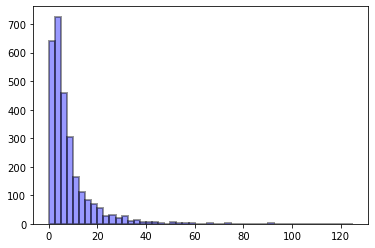

In [5]:
# Histograma Ratio_noshow
sns.distplot(x=df1['ratio_noshow'], kde=False, color='blue',
            hist_kws=dict(edgecolor="k", linewidth=2));
# sns.displot(data=df1, x="pasajeros_noshow");
# plt.hist(df1['ratio_noshow'],bins=np.arange(0,101,0.5), edgecolor='black');

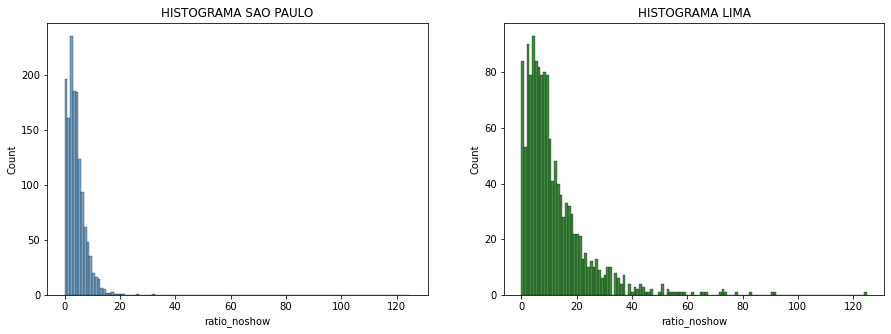

In [6]:
# Histogramas por Aeropuerto
bins = np.histogram_bin_edges(df1['ratio_noshow'], bins='auto')
f, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df1[df1['origen']=='SAO']['ratio_noshow'], bins=bins, color='steelblue', ax=axs[0])
sns.histplot(df1[df1['origen']=='LIM']['ratio_noshow'], bins=bins, color='darkgreen', ax=axs[1])
axs[0].title.set_text('HISTOGRAMA SAO PAULO')
axs[1].title.set_text('HISTOGRAMA LIMA')
#axs[0].set_xticks(np.arange(0,101,10))
#axs[0].set_xticklabels(np.arange(0,101,10), fontsize=14)
#axs[1].set_xticks(np.arange(0,101,10))
#axs[1].set_xticklabels(np.arange(0,101,10), fontsize=14)
plt.show()

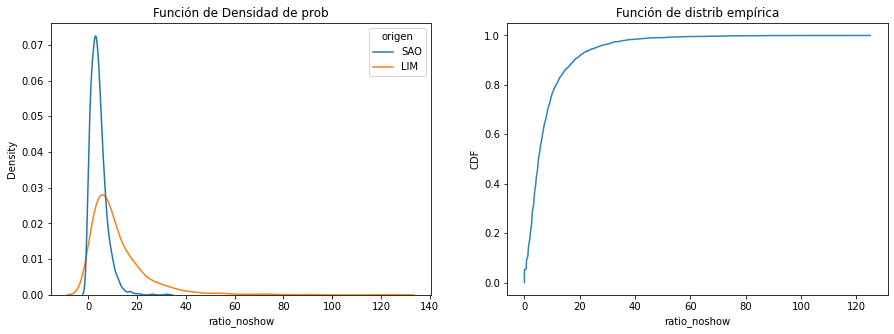

In [7]:
# Función de densidad y función de distribución empírica
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(data=df1, x="ratio_noshow",hue='origen', ax=axs[0])
axs[0].title.set_text('Función de Densidad de prob')
ecdf = ECDF(df1['ratio_noshow'])
plt.plot(ecdf.x, ecdf.y, color="#3182bd")
axs[1].title.set_text('Función de distrib empírica')
axs[1].set_ylabel('CDF')
axs[1].set_xlabel('ratio_noshow');

In [8]:
dia_sem, sem_anio = var_fecha('2019-10-16')

dia_sem: 3, sem_anio: 42


1. Criterios de selección muestra:
    * dia_sem: 3
    * hora_despegue: 1PM

In [9]:
# Selecciona muestra
df = df1.copy()
df = df[df['hora_despegue'].isin(['13:00:00']) & df['dia_sem'].isin([3])]
df.shape
# df = df[df['origen'].isin(['LIM'])]
# df = df[df['hora_despegue']>='12:30:00']
# df = df[df['hora_despegue']<='13:30:00']

(26, 14)

In [10]:
df[['pasajeros','pasajeros_noshow','ratio_noshow']].describe()

,pasajeros,pasajeros_noshow,ratio_noshow
count,26.000000,26.000000,26.000000
mean,131.076923,8.346154,6.460716
std,19.863380,5.570941,4.167563
min,79.000000,0.000000,0.000000
25%,123.000000,5.000000,3.378847
50%,135.500000,7.000000,6.109816
75%,144.500000,11.000000,8.949965
max,161.000000,23.000000,17.557252


Corresponde a un problema de distribución binomial discreta.

En promedio, los valores de la muestra tienen un un ratio_noshow de **6.46%** y desviación estandar de **4.16**. Luego, la probabilidad de éxito de un pasajero de abordar el vuelo es (1-0.0646) = **93.54%**

In [11]:
print(f"Número esperado de noshow: [{round(150*0.0646)}] pasajeros")

Número esperado de noshow: [10] pasajeros


### b.1) Considere ahora una distribución normal para analizar la distribución de probabilidad de los no-show. ¿Le parece adecuado usar esta distribución paramétrica? 

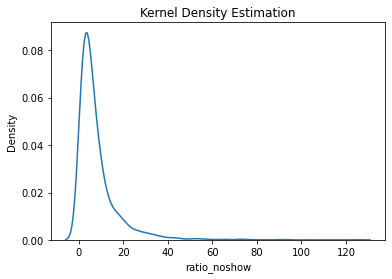

In [12]:
ax = sns.kdeplot(data=df1, x="ratio_noshow")
ax.set_title("Kernel Density Estimation");

**Respuesta:** Al observar el **KDE**, da la impresión de asemejarse al comportamiento de una distribución normal. A continuación se realizar varios test de normalidad.

In [13]:
# Test K^2
estadistico, p_valor = stats.normaltest(df1['ratio_noshow'])
if p_valor > 0.05:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente Gaussiana' % (estadistico, p_valor))
else:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente no es Gaussiana' % (estadistico, p_valor))

estadistico:2232.654, p-valor:0.000
Probablemente no es Gaussiana


In [14]:
# Test Shapiro-Wilk
estadistico, p_valor = stats.shapiro(df1['ratio_noshow'])
if p_valor > 0.05:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente Gaussiana' % (estadistico, p_valor))
else:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente no es Gaussiana' % (estadistico, p_valor))

estadistico:0.677, p-valor:0.000
Probablemente no es Gaussiana


In [15]:
from statsmodels.stats.diagnostic import lilliefors
estadistico, p_valor = lilliefors(df1['ratio_noshow'])
if p_valor > 0.05:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente Gaussiana' % (estadistico, p_valor))
else:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente no es Gaussiana' % (estadistico, p_valor))

estadistico:0.200, p-valor:0.001
Probablemente no es Gaussiana


In [16]:
from scipy.stats import jarque_bera
estadistico, p_valor = jarque_bera(df1['ratio_noshow'])
if p_valor > 0.05:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente Gaussiana' % (estadistico, p_valor))
else:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente no es Gaussiana' % (estadistico, p_valor))

estadistico:61512.368, p-valor:0.000
Probablemente no es Gaussiana


In [17]:
# Test Kolmogorov-Smirnov
estadistico, p_valor = stats.kstest(df1['ratio_noshow'], 'norm')
if p_valor > 0.05:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente Gaussiana' % (estadistico, p_valor))
else:
    print('estadistico:%.3f, p-valor:%.3f\nProbablemente no es Gaussiana' % (estadistico, p_valor))

estadistico:0.800, p-valor:0.000
Probablemente no es Gaussiana


Los resultados obtenidos nos permiten rechazar la Hipótesis de normalidad de los datos con un alto nivel de confianza. Podría realizarse transformación logarítmica.

### b.2) ¿Qué otras distribuciones se podrían utilizar para representar los no-show de forma paramétrica?

A continuación se calculan las distribuciones con mejor ajuste de acuerdo al criterio de información de Akaike (AIC):

In [18]:
datos = df1['ratio_noshow']

# Ajuste y comparación de distribuciones
# ==============================================================================
resultados = comparar_distribuciones(
                x=datos.to_numpy(),
                familia='realall',
                ordenar='aic',
                verbose=False)
resultados

1/29 Ajustando distribución: cauchy
2/29 Ajustando distribución: crystalball
3/29 Ajustando distribución: dgamma
4/29 Ajustando distribución: dweibull
5/29 Ajustando distribución: exponnorm
6/29 Ajustando distribución: genextreme
7/29 Ajustando distribución: genlogistic
8/29 Ajustando distribución: gennorm
9/29 Ajustando distribución: gumbel_l
10/29 Ajustando distribución: gumbel_r
11/29 Ajustando distribución: hypsecant
12/29 Ajustando distribución: johnsonsu
13/29 Ajustando distribución: kappa4
14/29 Ajustando distribución: laplace
15/29 Ajustando distribución: laplace_asymmetric
16/29 Ajustando distribución: loggamma


/Users/diegogutierrez/opt/anaconda3/envs/dash/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


17/29 Ajustando distribución: logistic
18/29 Ajustando distribución: loguniform
19/29 Ajustando distribución: moyal
20/29 Ajustando distribución: nct
21/29 Ajustando distribución: norm
22/29 Ajustando distribución: norminvgauss
23/29 Ajustando distribución: pearson3
24/29 Ajustando distribución: powernorm
25/29 Ajustando distribución: reciprocal
26/29 Ajustando distribución: skewnorm
27/29 Ajustando distribución: t
28/29 Ajustando distribución: truncnorm
29/29 Ajustando distribución: tukeylambda


/Users/diegogutierrez/opt/anaconda3/envs/dash/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:7901: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


,distribucion,log_likelihood,aic,bic,n_parametros,parametros
0,pearson3,-8.355550e+03,1.671710e+04,1.673491e+04,3,"{'skew': 2.056856689644893, 'loc': 8.204785672..."
1,laplace_asymmetric,-8.617642e+03,1.724128e+04,1.725909e+04,3,"{'kappa': 0.0029796968422668253, 'loc': -3.749..."
2,exponnorm,-8.623145e+03,1.725229e+04,1.727010e+04,3,"{'K': 1564.395968477586, 'loc': -0.01244393388..."
3,johnsonsu,-8.654929e+03,1.731786e+04,1.734160e+04,4,"{'a': -5.883442887622998, 'b': 1.1241778661850..."
4,norminvgauss,-8.666493e+03,1.734099e+04,1.736473e+04,4,"{'a': 31.520665739195238, 'b': 31.501971841832..."
5,genextreme,-8.679941e+03,1.736588e+04,1.738369e+04,3,"{'c': -0.4389654780754609, 'loc': 3.6737558842..."
6,nct,-8.679397e+03,1.736679e+04,1.739054e+04,4,"{'df': 2.3062363931077288, 'nc': 19.0425968812..."
7,moyal,-8.947228e+03,1.789846e+04,1.791033e+04,2,"{'loc': 3.85962149615375, 'scale': 2.879473611..."
8,skewnorm,-9.080929e+03,1.816786e+04,1.818566e+04,3,"{'a': 13898980.211343568, 'loc': -4.5212364641..."
9,gumbel_r,-9.146350e+03,1.829670e+04,1.830857e+04,2,"{'loc': 4.679310515409764, 'scale': 4.87877573..."


Graficar los mejores resultados, se observa cómo estas si representarían un buen ajuste.

##### pearson3

---------------------
Resultados del ajuste
---------------------
Distribución:   pearson3
Dominio:        [-inf, inf]
Parámetros:     {'skew': 2.056856689644893, 'loc': 8.204785672125002, 'scale': 8.438034148406441}
Log likelihood: -8355.55010968081
AIC:            16717.10021936162
BIC:            16734.90590798107


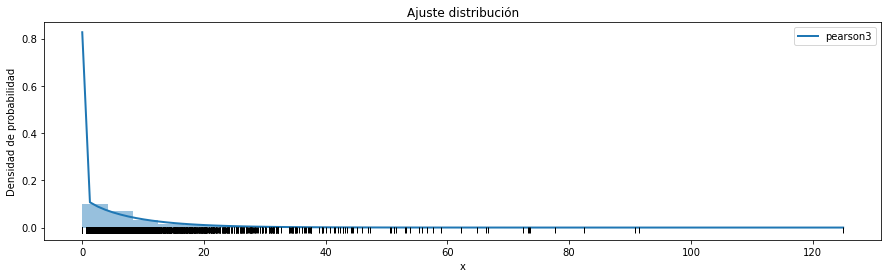

In [19]:
fig, ax = plt.subplots(figsize=(15,4))
plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][0],
    ax=ax
);

##### Laplace Asymmetric

---------------------
Resultados del ajuste
---------------------
Distribución:   laplace_asymmetric
Dominio:        [-inf, inf]
Parámetros:     {'kappa': 0.0029796968422668253, 'loc': -3.749571312875155e-08, 'scale': 0.02397485556795901}
Log likelihood: -8617.641644407335
AIC:            17241.28328881467
BIC:            17259.08897743412


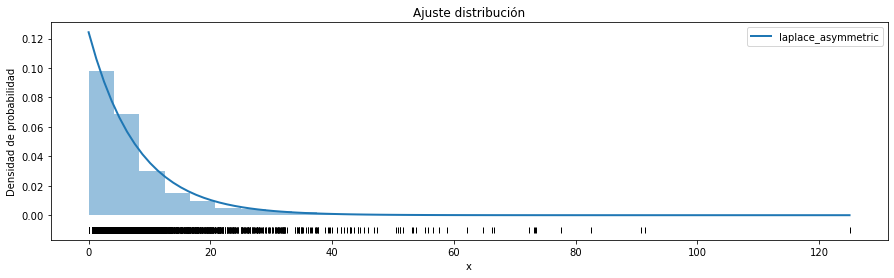

In [20]:
fig, ax = plt.subplots(figsize=(15,4))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][1],
    ax=ax
);

##### exponnorm

---------------------
Resultados del ajuste
---------------------
Distribución:   exponnorm
Dominio:        [-inf, inf]
Parámetros:     {'K': 1564.395968477586, 'loc': -0.01244393388232426, 'scale': 0.00510261295114935}
Log likelihood: -8623.144981875404
AIC:            17252.28996375081
BIC:            17270.09565237026


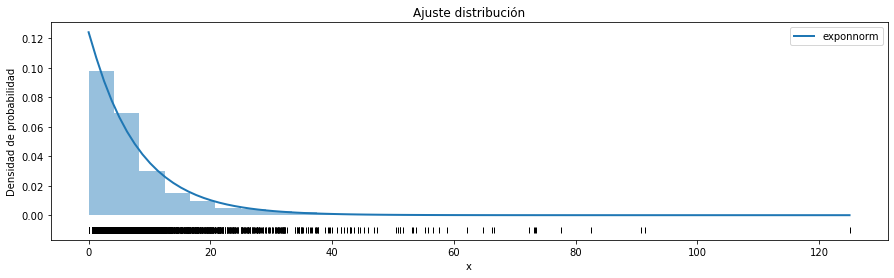

In [21]:
fig, ax = plt.subplots(figsize=(15,4))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][2],
    ax=ax
);

##### johnsonsu

---------------------
Resultados del ajuste
---------------------
Distribución:   johnsonsu
Dominio:        [-inf, inf]
Parámetros:     {'a': -5.883442887622998, 'b': 1.1241778661850912, 'loc': -0.8737584425704341, 'scale': 0.06417818968605449}
Log likelihood: -8654.928922764208
AIC:            17317.857845528415
BIC:            17341.59876368768


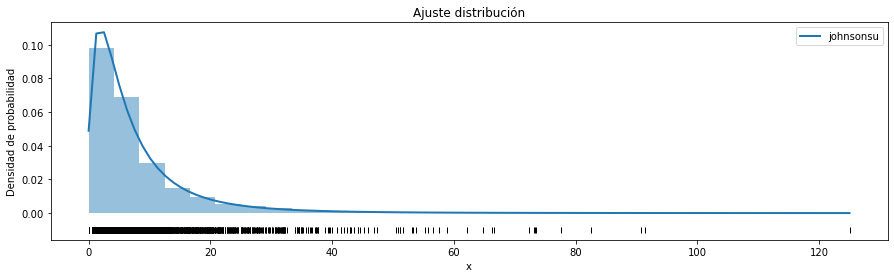

In [22]:
fig, ax = plt.subplots(figsize=(15,4))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][3],
    ax=ax
);

##### norminvgauss

---------------------
Resultados del ajuste
---------------------
Distribución:   norminvgauss
Dominio:        [-inf, inf]
Parámetros:     {'a': 31.520665739195238, 'b': 31.501971841832034, 'loc': -1.308582989665324, 'scale': 0.3223921534548492}
Log likelihood: -8666.492561992156
AIC:            17340.985123984312
BIC:            17364.72604214358


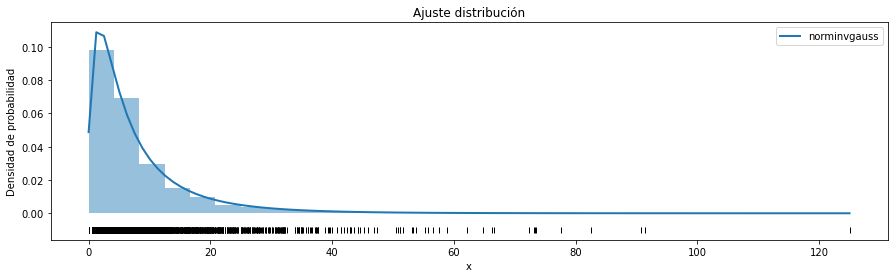

In [23]:
fig, ax = plt.subplots(figsize=(15,4))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][4],
    ax=ax
);

##### genextreme

---------------------
Resultados del ajuste
---------------------
Distribución:   genextreme
Dominio:        [-inf, inf]
Parámetros:     {'c': -0.4389654780754609, 'loc': 3.6737558842340667, 'scale': 3.595263819238961}
Log likelihood: -8679.940882891833
AIC:            17365.881765783666
BIC:            17383.687454403116


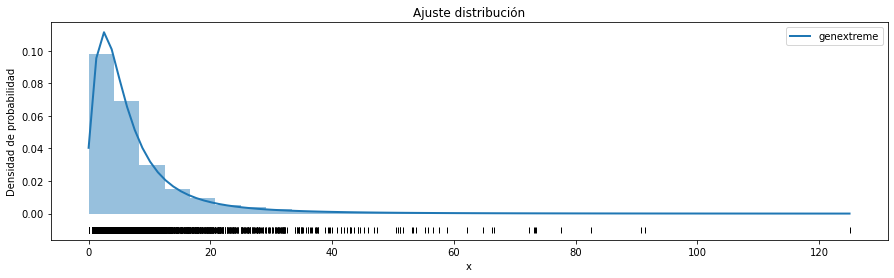

In [24]:
fig, ax = plt.subplots(figsize=(15,4))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][5],
    ax=ax
);

##### nct

---------------------
Resultados del ajuste
---------------------
Distribución:   nct
Dominio:        [-inf, inf]
Parámetros:     {'df': 2.3062363931077288, 'nc': 19.042596881282805, 'loc': -4.079955224573073, 'scale': 0.4126602258278186}
Log likelihood: -8679.397056569738
AIC:            17366.794113139476
BIC:            17390.535031298743


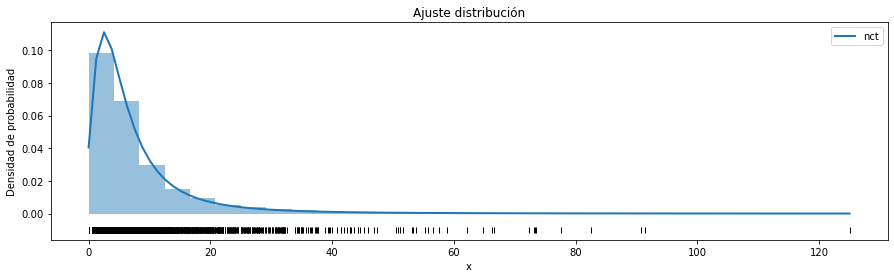

In [25]:
fig, ax = plt.subplots(figsize=(15,4))

plot_distribucion(
    x=datos.to_numpy(),
    nombre_distribucion=resultados['distribucion'][6],
    ax=ax
);

Las curvas de densidad de probabilidad para las demás distribuciones:

/Users/diegogutierrez/opt/anaconda3/envs/dash/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/Users/diegogutierrez/opt/anaconda3/envs/dash/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:7901: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)
/Users/diegogutierrez/opt/anaconda3/envs/dash/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6540: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
/Users/diegogutierrez/opt/anaconda3/envs/dash/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6540: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
/Users/diegogutierrez/opt/anaconda3/envs/dash/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by z

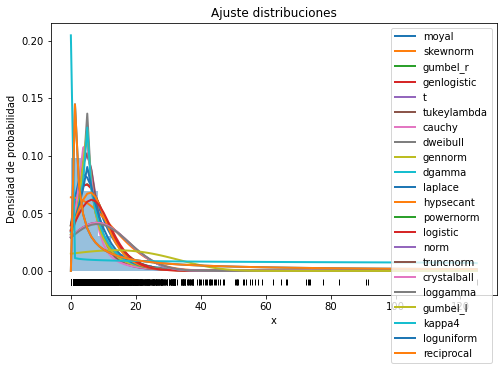

In [26]:
fig, ax = plt.subplots(figsize=(8,5))

plot_multiple_distribuciones(
    x=datos.to_numpy(),
    nombre_distribuciones=resultados['distribucion'][7:29],
    ax=ax
);

### c) Se entrega información adicional sobre el vuelo del 19 de octubre: (i) hay 10 pasajeros que viajan en business; y (ii) un 70% de los pasajeros tiene conexión. ¿Es útil esta información para mejorar la predicción no-shows del vuelo? De ser así: ¿cómo usaría esta información?

Sí sería útil y para demostrarlo lo replicaré `en general` usando un modelo de regresión lineal múltiple:

In [102]:
##### Agrega columna año, mes, dia y hora
meses = []
dias = []
anios = []
horas = []
for index, row in df1.iterrows():
    anio = row['fecha'].split('-')[0]
    mes = row['fecha'].split('-')[1]
    dia = row['fecha'].split('-')[2]     
    hora = row['hora_despegue'].split(':')[0]    
    
    anios.append(int(anio))
    meses.append(int(mes))
    dias.append(int(dia))
    horas.append(int(hora))
df1['anio'] = anios
df1['mes'] = meses
df1['dia'] = dias
df1['hora'] = horas

In [103]:
from sklearn.preprocessing import LabelEncoder
#from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [104]:
# Transforma columna origen a valor numérico
encoder = LabelEncoder()
df1['origen_enc'] = encoder.fit_transform(df1['origen'])

In [105]:
X = df1[['anio','mes','dia','dia_sem','sem_anio','hora','origen_enc']] #'pasajero_conexion','pasajero_negocio' ]]
y = df1['pasajeros_noshow']
# Divide en set de entrenamiento y testeo, con randomstate=42 para luego replicar.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state=42)
clf = LinearRegression()
clf.fit(X_train, y_train)
clf.predict(X_test)
resultado_modelo_inicial = clf.score(X_test,y_test)
print(f'El modelo inicial acertó en un: {resultado_modelo_inicial:.2%}')

El modelo inicial acertó en un: 21.52%


In [106]:
X = df1[['anio','mes','dia','dia_sem','sem_anio','hora','origen_enc', 'pasajero_conexion','pasajero_negocio' ]]
y = df1['pasajeros_noshow']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state=42)
clf2 = LinearRegression()
clf2.fit(X_train, y_train)
clf2.predict(X_test)
resultado_modelo_final = clf2.score(X_test,y_test)
print(f'El modelo final acertó en un: {resultado_modelo_final:.2%}')

El modelo final acertó en un: 25.99%


##### Se observa que, al incluir estas variables como explicativas, el modelo de regresión lineal múltiple mejoró en su predicción  en un 4.47%. 

##### Luego, al aplicar dichos modelos al vuelo consultado:

In [124]:
pred_noshow1 = clf.predict([[2019,10,16,3,42,13,1]])
pred_noshow2 = clf2.predict([[2019,10,16,3,42,13,1,150*0.7,10]])
print(f"Predicción modelo inicial: {(pred_noshow1)} pasajeros_noshow")
print(f"Predicción modelo final: {(pred_noshow2)} pasajeros_noshow")

Predicción modelo inicial: [5.99517409] pasajeros_noshow
Predicción modelo final: [5.76492267] pasajeros_noshow


#### Finalmente, no se observó gran cambio en la predicción final. Analizando las correlaciones, se puede observar que hay variables que no aportan a la predicción, por el año, mes y día.

In [126]:
corrM = df1.corr()
corrM

,vuelo,dia_sem,sem_anio,asientos,pasajeros,pasajero_conexion,pasajero_negocio,pasajeros_noshow,ratio_noshow,anio,mes,dia,hora,origen_enc
vuelo,1.000000,-0.003012,-0.084267,0.064619,0.022119,0.074467,0.035783,-0.029477,-0.029007,0.311184,-0.064377,-0.009266,0.075394,-0.004005
dia_sem,-0.003012,1.000000,0.004071,0.067805,0.130248,0.086913,0.052820,-0.092092,-0.093896,0.010268,0.004450,-0.003811,-0.022746,0.004090
sem_anio,-0.084267,0.004071,1.000000,0.138901,0.050218,-0.036207,-0.214461,0.078668,0.070507,-0.183123,0.964664,0.075543,0.028435,-0.001763
asientos,0.064619,0.067805,0.138901,1.000000,0.310193,0.202496,0.098114,0.027688,-0.009493,0.212739,0.150079,0.028613,0.044274,-0.000019
pasajeros,0.022119,0.130248,0.050218,0.310193,1.000000,0.739085,0.226584,-0.364911,-0.468601,0.102456,0.061184,0.045520,0.207550,0.256230
pasajero_conexion,0.074467,0.086913,-0.036207,0.202496,0.739085,1.000000,0.166438,-0.269068,-0.344439,0.093967,-0.034114,0.024857,0.202864,0.154900
pasajero_negocio,0.035783,0.052820,-0.214461,0.098114,0.226584,0.166438,1.000000,-0.167530,-0.169092,0.064387,-0.219337,0.006508,0.014594,0.041029
pasajeros_noshow,-0.029477,-0.092092,0.078668,0.027688,-0.364911,-0.269068,-0.167530,1.000000,0.969833,-0.029606,0.079600,0.026027,-0.259510,-0.435665
ratio_noshow,-0.029007,-0.093896,0.070507,-0.009493,-0.468601,-0.344439,-0.169092,0.969833,1.000000,-0.048040,0.067818,0.026110,-0.248449,-0.407082
anio,0.311184,0.010268,-0.183123,0.212739,0.102456,0.093967,0.064387,-0.029606,-0.048040,1.000000,-0.150395,-0.017323,-0.073944,0.000738
